In [1]:
!pip3 install torch torchvision


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1



 Early stopping triggered at epoch 37

 Final Test Accuracy: 86.67%


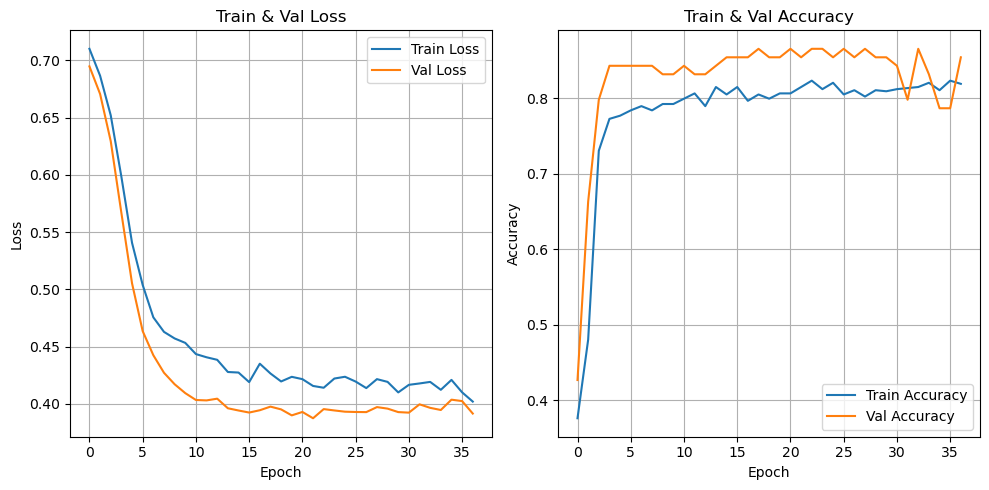

In [143]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


#dictionary
titanic_data = pd.read_csv('Titanic-Dataset.csv')

# DATA CLEANING
titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data['Age'].median())
titanic_data['Sex'] = titanic_data['Sex'].map({'male':0, 'female':1})
titanic_data['Fare'] = titanic_data['Fare'].fillna(titanic_data['Fare'].median())

# FEATURE ENGINEERING
titanic_data['FamilySize'] = titanic_data['SibSp'] + titanic_data['Parch'] + 1
titanic_data['FarePerPerson'] = titanic_data['Fare'] / titanic_data['FamilySize']

# Title
titanic_data['Title'] = titanic_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
titanic_data['Title'] = titanic_data['Title'].replace(
    ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
titanic_data['Title'] = titanic_data['Title'].replace(['Mlle','Ms'], 'Miss')
titanic_data['Title'] = titanic_data['Title'].replace('Mme','Mrs')
title_map = {"Mr": 0, "Rare": 1, "Master": 2, "Miss": 3, "Mrs": 4}
titanic_data["Title"] = titanic_data["Title"].map(title_map).fillna(0)

# Interactions
titanic_data['Fare_Pclass'] = titanic_data['Fare'] * titanic_data['Pclass']
titanic_data['Sex_Pclass'] = titanic_data['Sex'] * titanic_data['Pclass']
titanic_data['Sex_Age'] = titanic_data['Sex'] * titanic_data['Age']

# FEATURE SELECTION
feature_cols = [
    "Pclass", "Sex", "Age", "FamilySize",
    "Title", "FarePerPerson",
    "Sex_Age", "Fare_Pclass", "Sex_Pclass"
]

X = titanic_data[feature_cols]
y = titanic_data['Survived']

# -------------------------------
# TRAIN / VAL / TEST SPLIT
# -------------------------------
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_np, y_train_np, test_size=0.1/0.9, random_state=42)

#scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_val_scaled = scaler.transform(X_val_np)
X_test_scaled = scaler.transform(X_test_np)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train = torch.tensor(y_train_np.values, dtype=torch.float32).unsqueeze(1)
y_val   = torch.tensor(y_val_np.values, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test_np.values, dtype=torch.float32).unsqueeze(1)

batch_size = 16
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)


input_dim = X_train.shape[1]

#NN Architecture
model = nn.Sequential( nn.Linear(input_dim, 64), nn.ReLU(), nn.Dropout(0.15), nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.15), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1), nn.Sigmoid() )
#training hyperparameters
loss_fn = nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.0002)
epochs = 250
patience = 15
best_loss = float('inf')
epochs_no_improve = 0

train_losses, val_losses = [], []

train_accuracies, val_accuracies = [], []

for epoch in range(epochs):

    # Training 
    model.train()
    total_train_loss = 0
    y_train_all, y_train_pred_all = [], []
    for X_batch, y_batch in train_loader:
        optimiser.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimiser.step()
        total_train_loss += loss.item()

        # Track predictions for accuracy
        y_train_all.append(y_batch)
        y_train_pred_all.append((logits > 0.5).float())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Compute train accuracy
    y_train_all = torch.cat(y_train_all).cpu().numpy()
    y_train_pred_all = torch.cat(y_train_pred_all).cpu().numpy()
    train_acc = accuracy_score(y_train_all, y_train_pred_all)
    train_accuracies.append(train_acc)

    # Validation 
    model.eval()
    total_val_loss = 0
    y_val_all, y_val_pred_all = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            total_val_loss += loss.item()

            y_val_all.append(y_batch)
            y_val_pred_all.append((logits > 0.5).float())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Compute validation accuracy
    y_val_all = torch.cat(y_val_all).cpu().numpy()
    y_val_pred_all = torch.cat(y_val_pred_all).cpu().numpy()
    val_acc = accuracy_score(y_val_all, y_val_pred_all)
    val_accuracies.append(val_acc)

    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# Load best weights
model.load_state_dict(best_model_state)

# Testing accuracy
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test)
    y_pred = (y_pred_prob > 0.5).float()

accuracy = accuracy_score(y_test.numpy(), y_pred.numpy()) * 100
print(f"\n Final Test Accuracy: {accuracy:.2f}%")

# 7. Plot loss curve
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Val Loss')
plt.legend()
plt.grid(True)

# 8. Plot accuracy curve
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Val Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



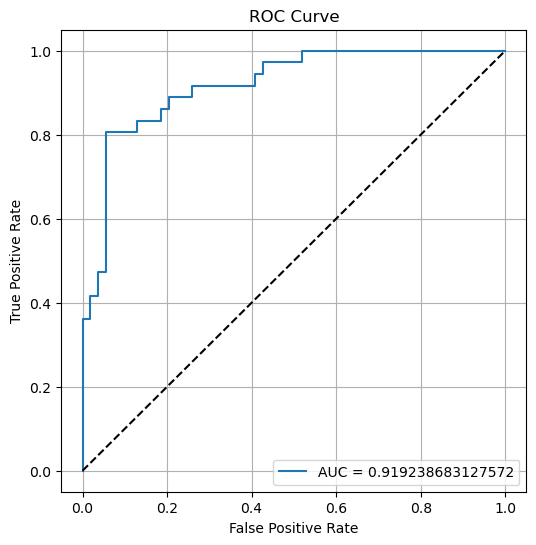


Optimal Threshold = 0.51297253

--- Metrics at threshold 0.5 ---
Precision: 0.8529411764705882
Recall:    0.8055555555555556
F1 Score:  0.8285714285714286


In [144]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

with torch.no_grad():
    probs = model(X_test).numpy().flatten()

y_true = y_test.numpy().flatten()

# roc-auc
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc = roc_auc_score(y_true, probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# optimal threshold
J = tpr - fpr
ix = np.argmax(J)
optimal_threshold = thresholds[ix]
print("\nOptimal Threshold =", optimal_threshold)

# metrics
y_pred_default = (probs > 0.5).astype(int)

precision_default = precision_score(y_true, y_pred_default)
recall_default = recall_score(y_true, y_pred_default)
f1_default = f1_score(y_true, y_pred_default)

print("\n--- Metrics at threshold 0.5 ---")
print("Precision:", precision_default)
print("Recall:   ", recall_default)
print("F1 Score: ", f1_default)


Confusion Matrix:
 [[49  5]
 [ 7 29]]


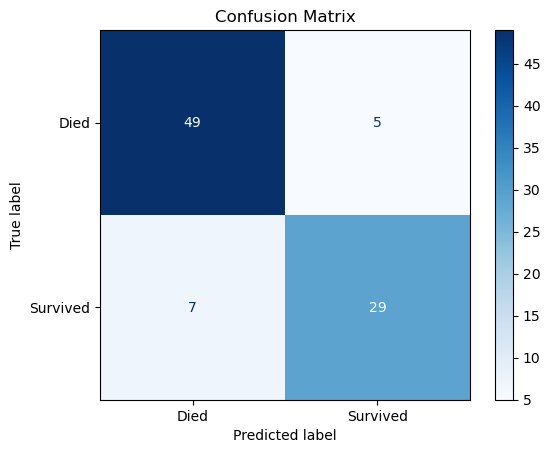

In [145]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert tensors to numpy
y_true = y_test.numpy().flatten()
y_pred_labels = y_pred.numpy().flatten()  # from your thresholded predictions

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:\n", cm)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Died", "Survived"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()